In [1]:
import numpy as np
import torch
import torch.utils.data as dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# -- modules -- :
import train_synthetic_signals191 as ran
import module_split as module
import RF_module as RF


In [2]:
def make_iterator_unique(dot_number, set_t, batch_size, shuffle):
    ''' 
    Makes an iterator for this experiment. It allows iteration through indices and the signals
    
    Returns an iterator.
    '''
        
    img_indexes = np.load(f'{set_t}/index_{set_t}_LFP_split.npy').astype(np.int)
    img_indexes = np.unique(img_indexes)
    data_indices = torch.from_numpy(img_indexes)
    
    dot_number = torch.from_numpy(dot_number)
    data = dataset.TensorDataset(dot_number, data_indices)

    return dataset.DataLoader(data, batch_size, shuffle = shuffle)

In [3]:
runname = 'synthetic_loaddot191'

In [4]:
device = -1
batch_size=4
# runname = ran.runname
# runname = '2_t300_feature25'
# runtype =ran.runtype
# model = ran.mode



# -----
# Model, loss, & optimizer
# -----

in_channels=191
model = ran.model
if device >= 0:
    model.cuda(device)


if in_channels == 2:
    inputtype = 'V1_V4'
if in_channels == 191:
    inputtype = 'all_channels'

set_t = 'training'

cuda0 = ran.cuda0
model.load_state_dict(torch.load(f'{runname}/epochs_197.model', map_location='cpu'))
model.eval()

# -----
# RF gaus maps
# ------
gaus = module.load_gausdata()

# seen_images = module.load_ydata()

# ------
# Testing
# ------
# nn_seen = module.load_ydata()
nn_seen_torch =torch.from_numpy(module.load_ydata())

dot_numbers_test = np.load(f'../../sorted_data/LFP/{set_t}/{set_t}_synth191final.npy')
iterator = make_iterator_unique(dot_numbers_test, set_t, batch_size, shuffle = False)

In [5]:
itera = iter(iterator)

In [6]:

hori_means, verti_means, std_avg = RF.extract_means_std()

confidence_mask = RF.make_confidence_mask(hori_means, verti_means, std_avg)
if device >= 0:
    confidence_mask = torch.from_numpy(confidence_mask.astype('float32')).to(cuda0)
else:
    confidence_mask = torch.from_numpy(confidence_mask.astype('float32'))




In [7]:
dot_number, img_indices = next(itera)

gaus_expand_to_batch = gaus.expand([len(img_indices), 191, 240, 240])
weight_images = dot_number[:,:,np.newaxis, np.newaxis].expand([len(img_indices), 191, 240, 240])     

# We want to use the dot number and repeat it (expand to gaus) such that it will have the same shape. 
#Then you multiply with the gaus_exapnd_go_batch!
inputs = module.select_type_inputs(inputtype, gaus_expand_to_batch, weight_images)


In [8]:
img0 = nn_seen_torch[img_indices]


target_batch = nn_seen_torch[img_indices]
target_batch = target_batch.transpose(3,1).transpose(2,3)

if device >=0:
    inputs = inputs.to(cuda0)
    target_batch = target_batch.to(cuda0)

    
out = model(inputs)

out *= confidence_mask.expand_as(out)
target_batch *= confidence_mask.expand_as(target_batch)


In [9]:
def my_plots(electrode , gaus_expand_to_batch, batch_nr, weight_images, out, target_batch ):
    V = electrode
    RF_inactive = gaus_expand_to_batch[batch_nr].sum(0)
    
    inputs = gaus_expand_to_batch * weight_images

    x = inputs[batch_nr][V] 
    print(x.shape)
    
    y = out[batch_nr].detach().cpu().numpy().transpose(1,2,0)
    t = target_batch[batch_nr].cpu().numpy().transpose(1,2,0)
    img = img0[batch_nr].cpu().numpy()
    
    filled = (img - t)+y


    plt.figure(figsize=(10,10))
    plt.suptitle(electrode, fontsize=20)
    plt.subplots_adjust(top=1.5)
    plt.rcParams['figure.figsize']=(10,10)

    plt.subplot(1,3,1)
    plt.imshow(y)
    plt.title('prediction')

    plt.subplot(1,3,2)
    plt.imshow(t)
    plt.title('target')

    plt.subplot(1,3,3)
    plt.imshow(img)
    plt.title('img')

    ###########
    # RECEPTIVE FIELDS
    ###########
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(x,  cmap='cividis')
    plt.title('input')
    # - - - - 
    plt.subplot(1,3,2)
    plt.imshow(RF_inactive,  cmap='cividis')
    plt.title('RF_inactive')

    plt.subplot(1,3,3)
    plt.imshow(filled, cmap = 'cividis')
    plt.title('filled in')


torch.Size([240, 240])
torch.Size([240, 240])
torch.Size([240, 240])


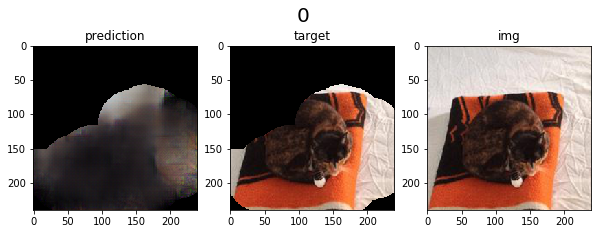

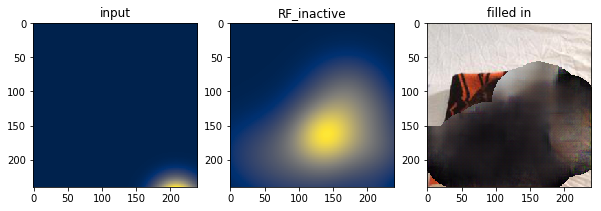

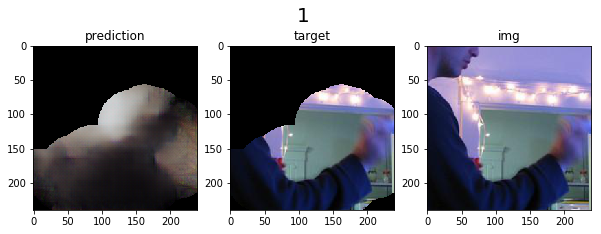

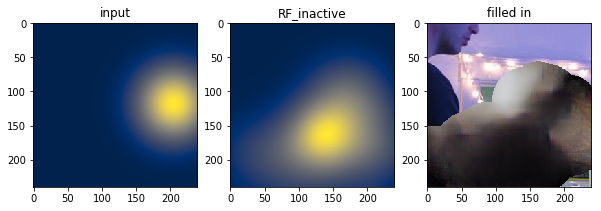

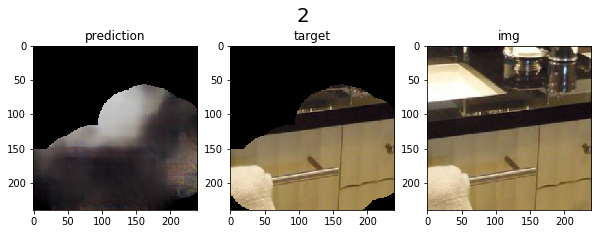

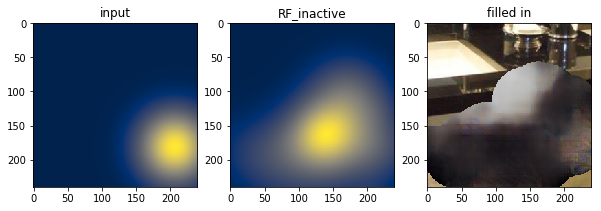

In [10]:
for e in range(3):
    my_plots(e,  gaus_expand_to_batch, e, weight_images, out, target_batch)
# my_plots(1,  gaus_expand_to_batch, 0, weight_images, out, target_batch)

torch.Size([240, 240])
torch.Size([240, 240])
torch.Size([240, 240])


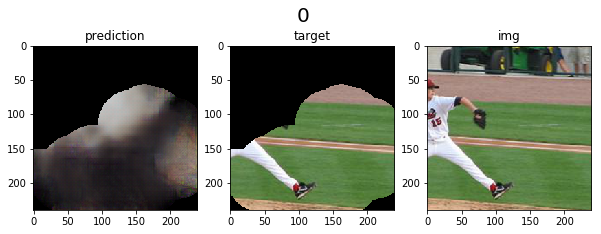

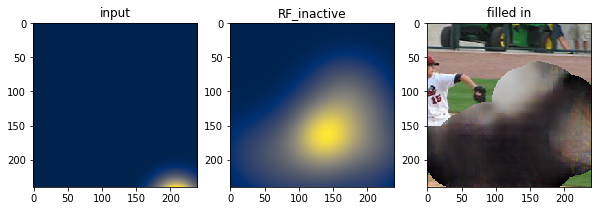

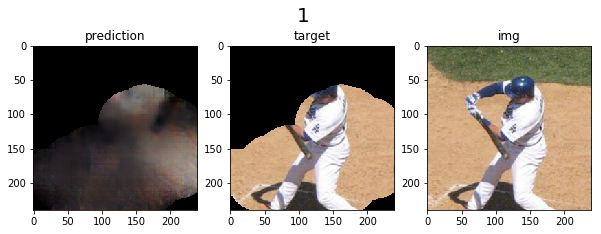

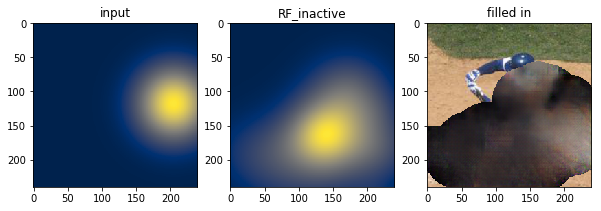

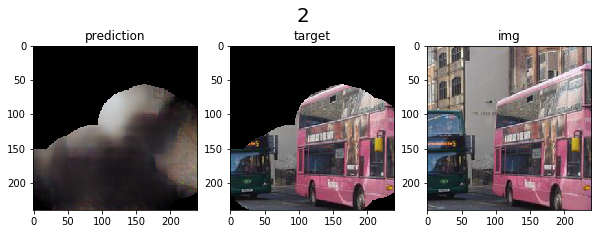

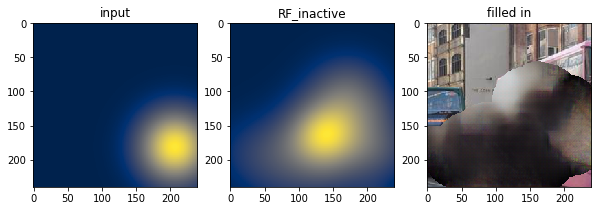

In [20]:
#TESTING

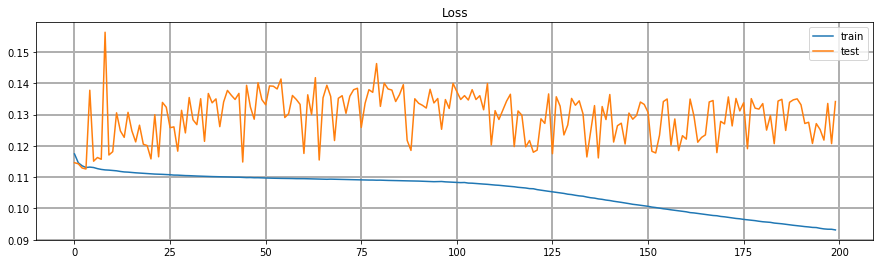

In [11]:
loss_train = np.load(runname + '/loss_train.npy', allow_pickle=True)
loss_test = np.load(runname+ '/loss_test.npy', allow_pickle=True)
epochs = len(loss_train)
plt.figure(figsize=(15,4))
# plt.ylim((1.1,2))
from_n = 0
to_n = epochs

plt.plot(loss_train[from_n:to_n], label='train', )
plt.plot(loss_test[from_n:to_n], label = 'test')
plt.legend()
plt.grid(True, linewidth=2)
plt.title('Loss')
plt.show()